#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    TimeSeriesSplit,
    cross_val_score
)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [4]:
data.info()
print('Ряд непрерывен:', data.index.is_monotonic)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
Ряд непрерывен: True


**Ресемплинг**

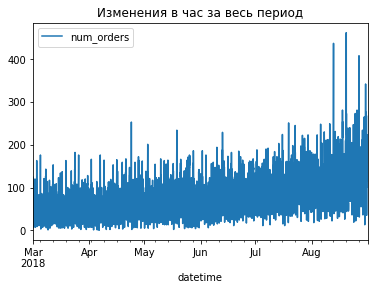

In [5]:
data = data.resample('1H').sum()
data.plot()
plt.title('Изменения в час за весь период')
plt.show()

**Вывод**

- есть тренд роста увеличения заказов такси 

## Анализ

In [6]:
data_week = data['2018-08-25':'2018-08-31']
# создаем срез данных за последнею неделю

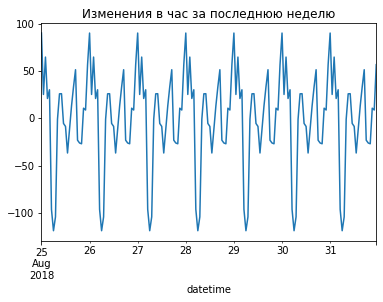

In [7]:
seasonal_decompose(data_week).seasonal.plot()
plt.title('Изменения в час за последнюю неделю')
plt.show()

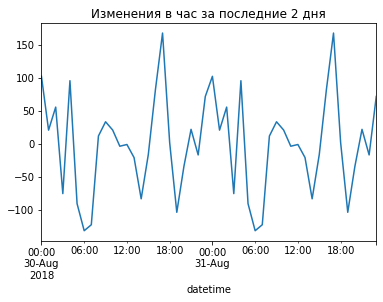

In [8]:
seasonal_decompose(data['2018-08-30':'2018-08-31']).seasonal.plot()
plt.title('Изменения в час за последние 2 дня')
plt.show()

**Выводы**

- прослеживается восходящий тренд
- меньше всего заказов на 6 утра, а пик заказов с 17-18 часов

## Обучение

In [9]:
def make_features(data, max_lag, rolling_mean_size):

    data['hour'] = data.index.hour
    
    for i in range(1, max_lag+1):
        data[f'lag_{i}'] = data['num_orders'].shift(i)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()
    
    return data

#содаем функцию для создания дополнительных признаков в датасете

In [10]:
df = make_features(data_week, 2, 24)

# задаем параметры функции создания новых признаков

In [18]:
df.shape

(144, 5)

In [11]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train_x = train.drop('num_orders', axis=1)
train_y = train['num_orders']
test_x = test.drop('num_orders', axis=1)
test_y = test['num_orders']

df.head()

,num_orders,hour,lag_1,lag_2,rolling_mean
datetime,,,,,
2018-08-26 00:00:00,281,0,174.0,155.0,143.666667
2018-08-26 01:00:00,156,1,281.0,174.0,144.000000
2018-08-26 02:00:00,148,2,156.0,281.0,140.250000
2018-08-26 03:00:00,267,3,148.0,156.0,139.750000
2018-08-26 04:00:00,114,4,267.0,148.0,143.083333


In [12]:
pred_previous = pd.DataFrame(test_y, index=test.index).shift()
pred_previous.iloc[0] = train_y.iloc[-1]

results_dict = {}
results_dict['pred_previous'] = mean_squared_error(test_y, pred_previous)**0.5

#results_dict['pred_previous'] = (mean_squared_error(train_y, pred_previous)**0.5)
pd.DataFrame(results_dict, index=['RMSE_test'])

# проверим метрикой RMSE если прогнозы будут предыдущими значениями

,pred_previous
RMSE_test,37.657226


In [13]:
constant = pd.DataFrame(np.ones(len(train_y))*train_y.mean(), index=train.index)

#results_dict['constant'] = ['NaN']
results_dict['constant'] = mean_squared_error(train_y, constant)**0.5
pd.DataFrame(results_dict, index=['RMSE_train'])

# проверим метрикой RMSE если прогнозы будут постоянными и равны среднему значению

,pred_previous,constant
RMSE_train,37.657226,66.062689


### LinearRegression

In [14]:
model_lin = LinearRegression()
model_lin.fit(train_x, train_y)
predict_train_lin = model_lin.predict(train_x)
#predict_test_lin = model_lin.predict(test_x)

results_dict['LinearRegression'] = [mean_squared_error(train_y, predict_train_lin)**0.5]
#results_dict['LinearRegression'].append(mean_squared_error(test_y, predict_test_lin)**0.5)
#pd.DataFrame(results_dict, index=['RMSE_train', 'RMSE_test'])
pd.DataFrame(results_dict, index=['RMSE_train'])

,pred_previous,constant,LinearRegression
RMSE_train,37.657226,66.062689,59.03669


In [15]:
print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', cross_val_score(model_lin, train_x, train_y, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean())

Значение метрики RMSE на обучающей выборке для LinearRegression -82.14840104748666


### LGBMReg

In [ ]:
params = {
    'learning_rate': [0.1, 0.6],
    'max_depth': [3, 9],
    'num_leaves': [30, 90, 10],
    'boost': ['gbdt']
}

tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(LGBMRegressor(random_state=12345),
                    param_grid=params,
                    cv=tscv,
                    scoring='neg_root_mean_squared_error',
                    verbose=1)

grid.fit(train_x, train_y)
print(grid.best_params_)
print(grid.best_score_)

In [17]:
LGBM_model = LGBMRegressor(boost='gbdt', learning_rate=0.1, max_depth=3, num_leaves=30)
LGBM_model.fit(train_x, train_y)
LGBM_predict_train = LGBM_model.predict(train_x)

results_dict['LGBM'] = mean_squared_error(train_y, LGBM_predict_train)**0.5
pd.DataFrame(results_dict, index=['RMSE_train'])

,pred_previous,constant,LinearRegression,LGBM
RMSE_train,37.657226,66.062689,59.03669,38.710417


**Выводы**

- для проверки на адекватность были получены показатели метрики RMSE для прогнозов по предыдущим показаниям и константе равной среднему значению
- были обучены две модели LR и LGBM - лучшие показатели метрики у LGBM

## Тестирование

In [17]:
LGBM_predict_test = LGBM_model.predict(test_x)
RMSE = mean_squared_error(test_y, LGBM_predict_test)**0.5
RMSE


28.55441783470212

<AxesSubplot:title={'center':'Результаты модели за тестовый период'}, xlabel='Период', ylabel='Кол-во заказов'>

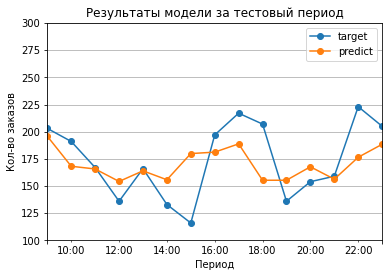

In [63]:

data_LGBM_tar = pd.DataFrame({'target':list(test_y), 'predict':list(LGBM_predict_test)}, index=test_y.index)

data_LGBM_tar.plot(
    style='o-', grid=True, ylim = (100, 300),
    title = 'Результаты модели за тестовый период',
    ylabel = 'Кол-во заказов', 
    xlabel = 'Период'
)



**Выводы**

- лучшая модель с показателем RMSE - 28,5 на тестовой выборке LGBMRegressor(boost='gbdt', learning_rate=0.1, max_depth=3, num_leaves=30)

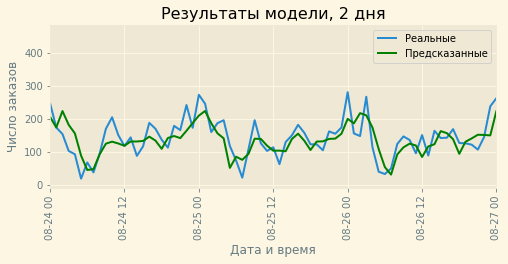